* Student : Thiziri NAIT SAADA
* Instructor : Alexandre D'ASPREMONT
* MVA 2020

# Convex Optimization : Homework 3


## Dual problem

<img src="theorie-1.pdf">
<img src="theorie-2.pdf">



In [1]:
## Importations

import numpy as np
import time
from matplotlib import pyplot as plt

### High dimensional setting : 
* n = 10
* d = 200

In [2]:
## Parameters
n = 10 # nb of samples
d = 200  # dimension of each sample
lambd = 10 # positive constant of regularization of the L1 penalty term 
alpha = 0.25 # parameter for backtracking line search
beta = 0.2 # parameter for backtracking line search
mu = 2 # parameter of the barrier method
t0 = 1 # initial point of the barrier method 
v_0 = np.zeros(n) # initial point
eps = 10**(-6)
max_iter = 150

## Generation of samples, features between 0 and 100, labels between 0 and 1
X = np.random.random((n,d))
w = np.random.randn(d)
y = X@w + np.random.randn(n)

## Constants of the QP problem
p = - y
Q = 1/2 * np.eye(n)
A = np.concatenate([X.T, -X.T])
b = lambd * np.ones(2*d)

In [3]:
## Main functions needed

def f(Q, p, x):
    return x.T @ Q @ x + p.T @ x

def phi(A, b, v):
    return - np.sum(np.log(b - A@v)) 

def objective_barrier(Q, p, A, b, t, x):
    return t * f(Q, p, x) + phi(A, b, x)

def gradient_barrier(Q,p,A,b,t,v):
    s = 1./(b - A@v)
        
    return t * (2 * Q @ v + p) + A.T @ s

def hessian_barrier(Q,A,b,t,v):
    s = 1./(b- A@v)
    
    return t * 2 * Q + A.T @ np.diag(s)**2 @ A


## Centering phase

In [4]:
def centering_step(Q,p,A,b,t,v0,eps, nb_iterations = max_iter): 
    t0 = time.time()
    v_seq = []
    decrement_seq = []
    k = 0
    f_values = []
    u = v0
    while(k < max_iter):
        k+= 1
        
        # computing the Newton step
        gradient = gradient_barrier(Q,p,A,b,t,u)
        hessian = hessian_barrier(Q,A,b,t,u)
        hessian_inverse = np.linalg.pinv(hessian)
        delta_v = - hessian_inverse @ gradient
        
        # computing the decrement 
        decrement = gradient.T @ hessian_inverse @ gradient
        decrement_seq = decrement_seq + [decrement]
        f_values = f_values + [f(Q,p,u)]
        v_seq = v_seq + [u]

        # Stopping criterion
        if decrement/2 <= eps : 
            break
        
        # Bactracking line search
        step_size = 1
        
        while (np.sum(1 * ((A @ (u + step_size * delta_v) - b) < 0)) < b.shape[0]) or (objective_barrier(Q, p, A, b, t, u + step_size * delta_v) - (objective_barrier(Q, p, A, b, t, u) + alpha * step_size * gradient.T @ delta_v) > eps):
            step_size = step_size * beta
        
        # Updating
        u = u + step_size * delta_v
        
    return v_seq, decrement_seq, f_values

## Barrier Method

In [5]:
def barr_method(Q,p,A,b,v0,eps,mu):
    t = 0.01 ## starting point t0, defined by heuristic
    v_init = v0
    v_sequ = []
    inner_it = 0
    upper_dual_gaps = []
    f_values = []
    decrements=[]
    outer = []
    
    while ((2*d)/t > eps):
        
        # Duality gap 
        gap = (2*d)/t
        
        # Centering step
        v = centering_step(Q,p,A,b,t,v_init,eps)
        
        # Updating
        v_init = v[0][-1]
        v_sequ = v_sequ + v[0] 
        f_values = f_values + v[2]
        decrements = decrements + v[1]
      
        # Increasing t
        t = mu * t
        upper_dual_gaps = upper_dual_gaps + [gap]
                
        # Nb of outer iterations
        outer += [inner_it + len(v[0])]
        
        # Nb of inner iterations
        inner_it = inner_it + len(v[0])

    return v_sequ, upper_dual_gaps, outer, inner_it, f_values, decrements

In [6]:
print('v_0', v_0)

t = 1
v_sequence = barr_method(Q,p,A,b,v_0,eps,mu)

print('v_final ', v_sequence[0][-1])

v_0 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
v_final  [ 0.98417993  3.65556912 -0.84565486  6.91840029  0.41510411 -0.63695728
  2.67107719 -1.52514017 -5.22152214 -0.34118195]


## Let's play with hyperparameter $\mu$

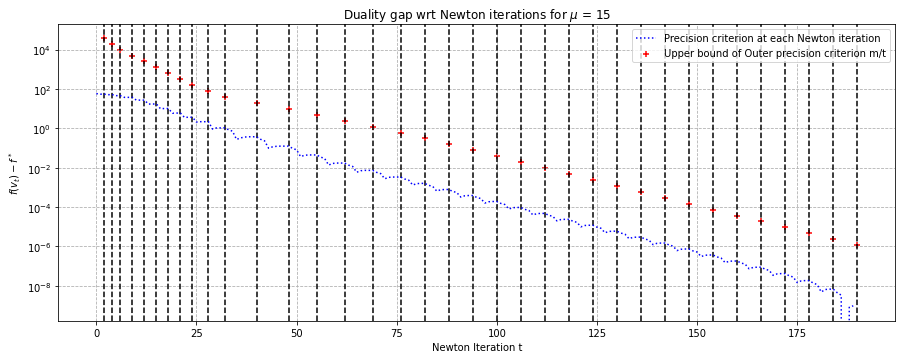

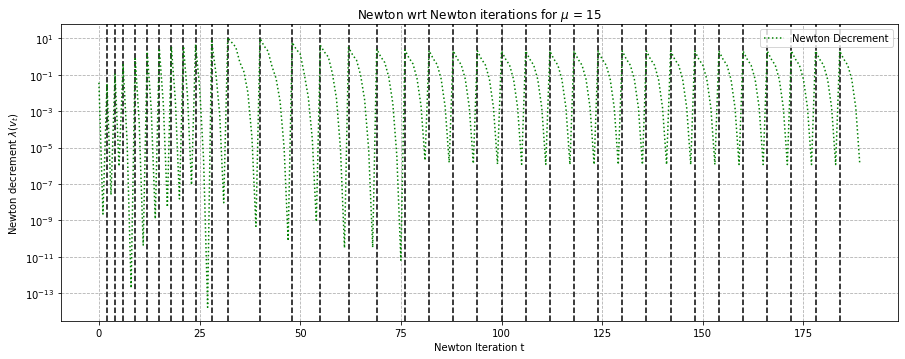

In [9]:
plt.figure(figsize=(15, 12))
plt.subplot(2, 1, 1)
plt.xlabel('Newton Iteration t')
plt.ylabel('$f(v_t) - f^*$')
plt.scatter(v_sequence[2], v_sequence[1], color = 'r',marker = "+", label = 'Upper bound of Outer precision criterion m/t')
plt.yscale('log')
plt.grid(True,which="both", linestyle='--')

for xc in v_sequence[2]:
    plt.axvline(x=xc, color='k', linestyle='--')

f_star = min(v_sequence[4])


plt.plot(np.arange(v_sequence[3]),v_sequence[4] - f_star, color = 'b',linestyle=':', label = 'Precision criterion at each Newton iteration')
plt.title("Duality gap wrt Newton iterations for $\mu$ = 15")

plt.legend()
plt.show()

plt.figure(figsize=(15, 12))
plt.subplot(2, 1, 2)
plt.xlabel('Newton Iteration t')
plt.ylabel('Newton decrement $\lambda(v_t)$')
plt.yscale('log')
plt.grid(True,which="both", linestyle='--')
for xc in v_sequence[2][:-1]:
    plt.axvline(x=xc, color='k', linestyle='--')
plt.plot(np.arange(v_sequence[3]),v_sequence[5], color = 'g',linestyle=':', label = 'Newton Decrement')
plt.title("Newton wrt Newton iterations for $\mu$ = 15")

plt.legend()
plt.show()



In [10]:
def plot_fig(mu,t0):
    
    plt.figure(figsize=(15, 12))
    plt.subplot(2, 1, 1)
    plt.xlabel('Newton Iteration t')
    plt.ylabel('$f(v_t) - f^*$')
    plt.scatter(v_sequence[2], v_sequence[1], color = 'r',marker = "+", label = 'Upper bound of Outer precision criterion m/t')
    plt.yscale('log')
    plt.grid(True,which="both", linestyle='--')

    for xc in v_sequence[2]:
        plt.axvline(x=xc, color='k', linestyle='--')

    f_star = min(v_sequence[4])

    plt.plot(np.arange(v_sequence[3]),v_sequence[4] - f_star, color = 'b',linestyle=':', label='Precision criterion at each Newton iteration')
    plt.title("Duality gap wrt Newton iterations for $\mu$ = " + str(mu))

    plt.legend()
    plt.show()

    plt.figure(figsize=(15, 12))
    plt.subplot(2, 1, 2)
    plt.xlabel('Newton Iteration t')
    plt.ylabel('Newton decrement $\lambda(v_t)$')
    plt.yscale('log')
    plt.grid(True,which="both", linestyle='--')
    for xc in v_sequence[2]:
        plt.axvline(x=xc, color='k', linestyle='--')
    plt.plot(np.arange(v_sequence[3]),v_sequence[5], color = 'g',linestyle=':', label = f'Newton Decrement , time $= {time.time() - t0}$')
    plt.title("Newton wrt Newton iterations for $\mu$ = " + str(mu))
    plt.legend()
    plt.show()


## Influence of $\mu$


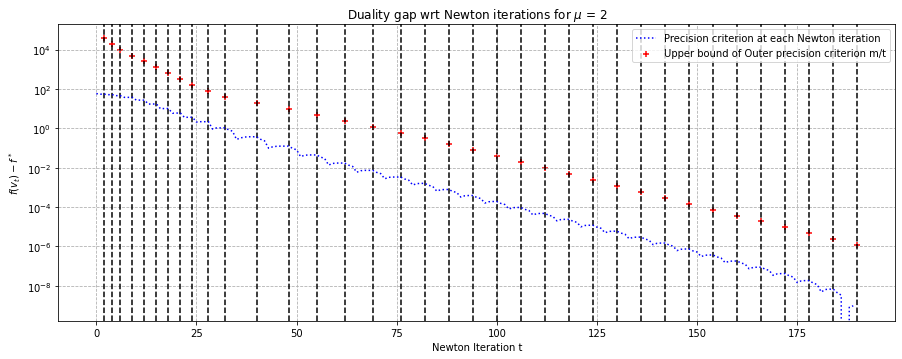

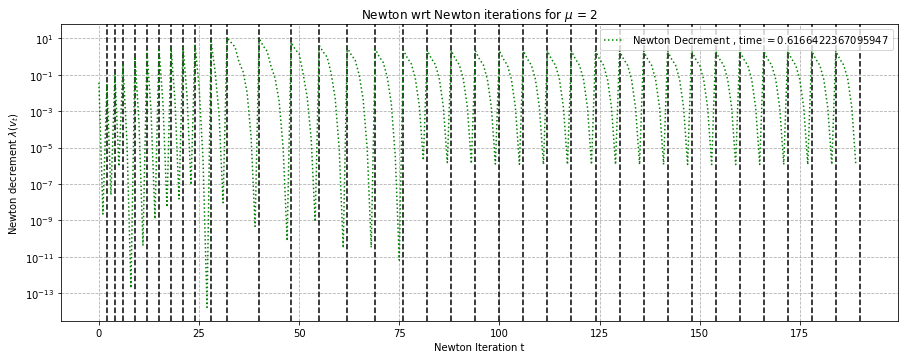

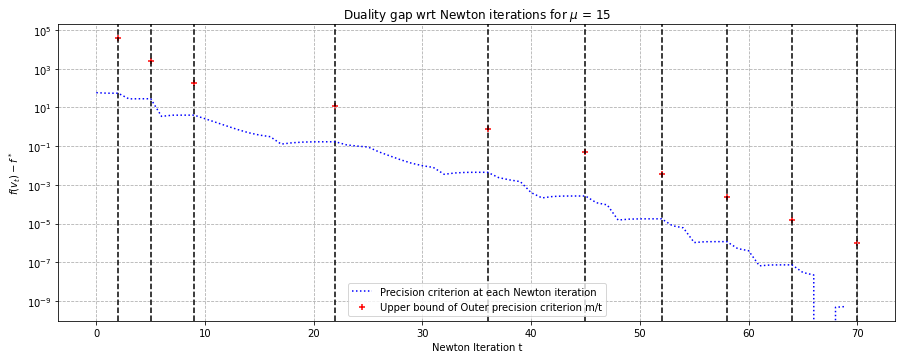

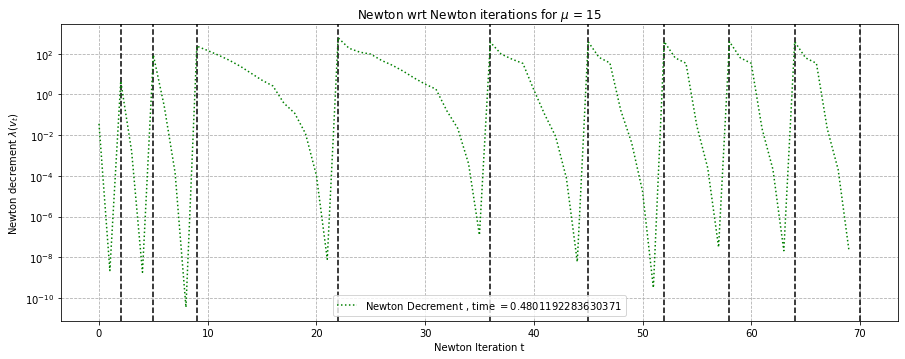

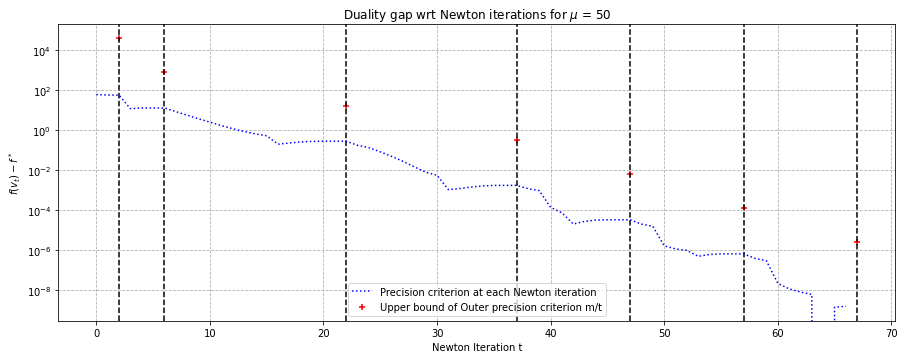

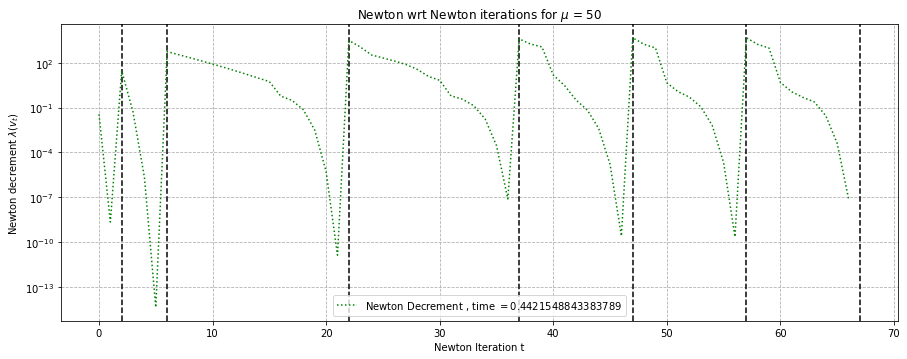

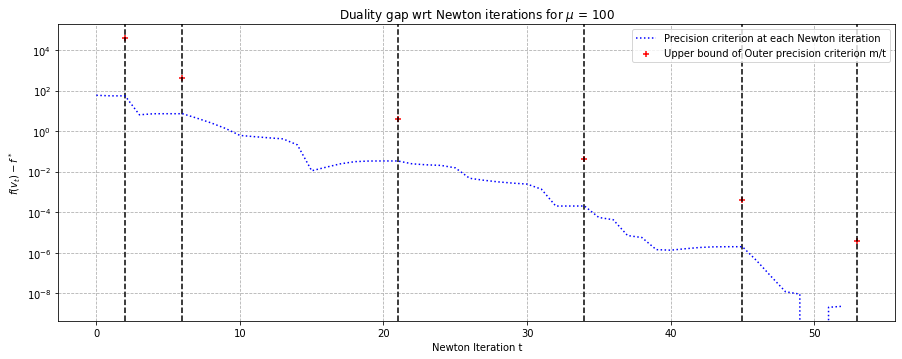

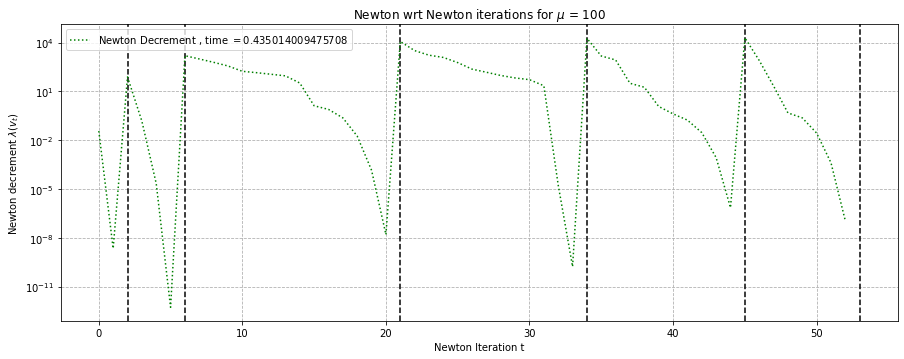

In [11]:
list_mu = [2,15,50,100]
t = 1

for mu in list_mu: 
    t0 = time.time()
    v_sequence = barr_method(Q,p,A,b,v_0,eps,mu)
    plot_fig(mu,t0)

### To sum up 

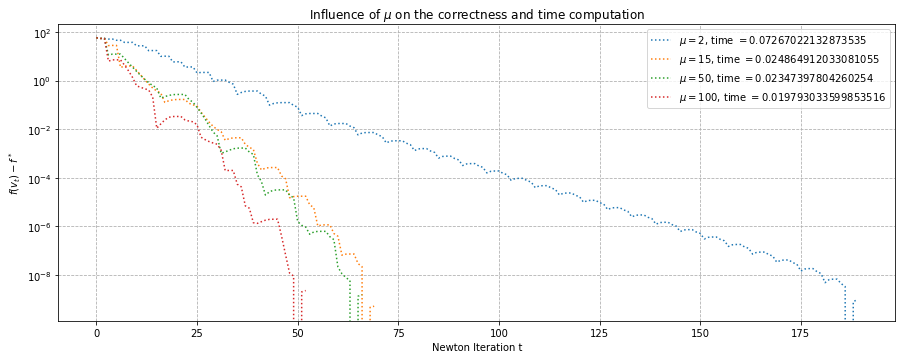

In [12]:
plt.figure(figsize=(15, 12))
plt.subplot(2, 1, 2)
plt.xlabel('Newton Iteration t')
plt.ylabel('$f(v_t) - f^*$')
plt.yscale('log')
plt.grid(True,which="both", linestyle='--')
for mu in list_mu: 
    t0 = time.time()
    v_sequence = barr_method(Q,p,A,b,v_0,eps,mu)
    f_star = min(v_sequence[4])

    plt.plot(np.arange(v_sequence[3]),v_sequence[4] - f_star,linestyle=':', label=f'$\mu = {mu}$, time $= {time.time() - t0}$')

plt.legend()
plt.title('Influence of $\mu$ on the correctness and time computation')
plt.show()

* Larger values for $\mu$ lead to faster computation (less Newton iterations performed) for barely the same number of digit precision.
* It seems to exist a kind of bottleneck for the convergence speed when $\mu$ gets close to 100/150.
* We can see a form of stairs, denoting the centering phase (the number of Newton steps increases while the error is not improved

## Recover w

<img src="recover-1.pdf">
<img src="recover-2.pdf">

In [13]:
## Set up

mu = 15
v_sequence = barr_method(Q,p,A,b,v_0,eps,mu)
v_star = v_sequence[0][-1]

In [14]:
## Locations of non zeros coefficients within optimal primal solution w*

ind = np.where(np.abs(np.abs(X.T@v_star) - lambd)< eps)
ind[0]

array([144, 161])

In [16]:
## Removing redundancy within X, keeping columns of index ind

X_tilde = X[:,ind[0]]
X_tilde_inverse = np.linalg.pinv(X_tilde)
w_reco = X_tilde_inverse @ (y - v_star)

w_recover = np.zeros(d)
k = 0
for i in ind[0] : 
    w_recover[i] += w_reco[k]
    k+=1

w_recover ## SPARSE VECTOR

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

### Impact of $\mu$ on the sparsity of w

Text(0.5, 1.0, 'No influence on sparsity of w wrt to $\\mu$')

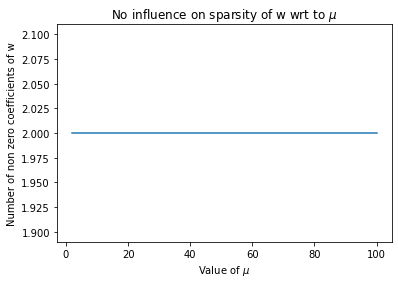

In [17]:
sparsity = []
for mu in list_mu : 
    v_sequence = barr_method(Q,p,A,b,v_0,eps,mu)
    v_star_mu = v_sequence[0][-1]
    ind_mu = np.where(np.abs(np.abs(X.T@v_star_mu) - lambd)< eps)
    sparsity.append(len(ind_mu[0]))
    
plt.plot(list_mu, sparsity)
plt.xlabel("Value of $\mu$")
plt.ylabel("Number of non zero coefficients of w")
plt.title("No influence on sparsity of w wrt to $\mu$")

### Check strong duality holds for this recovered w

In [18]:
## Solving the dual (actually we considered minus the dual of the original pb)

print('Minimum of the dual ', f(Q,p,v_star))

print('Dual optimal solution ', v_star)

Minimum of the dual  -58.180449207037256
Dual optimal solution  [ 0.98417993  3.65556912 -0.84565486  6.91840029  0.41510411 -0.63695728
  2.67107719 -1.52514017 -5.22152213 -0.34118195]


In [19]:
## Checking the result with CVXOPT

import cvxopt as cvx

cvx.solvers.options['show_progress'] = False
sol = cvx.solvers.qp(P=2 * cvx.matrix(Q), q=cvx.matrix(p), G=cvx.matrix(A), h=cvx.matrix(b))
print('argmin', sol['x'], 'min', sol['primal objective'])

argmin [ 9.84e-01]
[ 3.66e+00]
[-8.46e-01]
[ 6.92e+00]
[ 4.15e-01]
[-6.37e-01]
[ 2.67e+00]
[-1.53e+00]
[-5.22e+00]
[-3.41e-01]
 min -58.18044873708327


In [20]:
## Strong duality must hold for optimal primal solution

def primal(X,y,w):
    return 1/2 * np.linalg.norm(X@w - y, ord=2)**2  + lambd * np.linalg.norm(w, ord=1) 

primal(X,y,w_recover)

58.18044921223919

* As we considered - the dual of the original problem, we obtained the opposite of the minimum value reached. 
* Strong duality holds as seen in the lectures (Convex problem + Slater's conditions)